### TODO
* Add recording and plot for how many steps needed each episode

# Ex6.9: Windy Grid-World with Kings moves using SARSA on-Policy Control

![Bild](ex65.png)

Re-solve the windy grid-world assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

# Ex6.10: Stochastic Wind

Re-solve the windy grid-world task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

## Defining the environment

In [2]:
class Grid:
    '''Class defining the environment'''
    
    def __init__(self, shapex, shapey, wind, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.wind   = wind
        self.start  = start
        self.goal   = goal
    
    def get_wind(self, pos):
        '''pos : tuple(int, int) : position on grid'''
        return self.wind[pos[1]]
    
    def set_start(self, pos):
        '''pos : tuple(int, int) : position of new start'''
        self.start = pos
        
    def set_goal(self, pos):
        '''pos : tuple(int, int) : position of new goal'''
        self.goal = pos
    
    def is_in_grid(self, pos):
        '''pos : tuple(int, int) : position on grid'''
        return ((0 <= pos[0] < self.shapex) and (0 <= pos[1] < self.shapey))
    
    def show_path(self, path):
        '''path : list(tuple(int, int)) : List of legal moves'''
        
        length        = len(path)
        grid          = np.full((self.shapex, self.shapey), -0.1)
        fade          = np.linspace(0.1, 1, num=length)
        
        pos           = self.start
        grid[pos]     = 0
        
        for i in range(length):
            pos       = move(self, pos, path[i])
            grid[pos] = fade[i]
            
        grid[self.goal] = 1
        
        plt.imshow(grid)

In [3]:
height = 7
width  = 10
start  = (3, 0)
goal   = (3, 7)
wind   = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
grid   = Grid(height, width, wind, start, goal)

## Setting up

In [4]:
king_moves      = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
king_moves_noop = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1), (0, 0)]
compass_moves   = [(-1, 0), (0, -1), (0, 1), (1, 0)]

stochastic_wind = False
moves           = []
move_idx        = 0

In [5]:
def setup(move_type, stochastic=False):
    '''
    move_type  : list(tuple(int, int)) : List of available moves
    stochastic : bool                  : Decides if wind should be stochastic
    
    Sets up environment before calling sarsa(...)
    '''
    
    global moves, stochastic_wind, move_idx
    
    moves = move_type
    move_idx = {moves[i] : i for i in range(len(moves))}
    stochastic_wind = stochastic

In [6]:
def calc_new_pos(grid, pos, act):
    '''
    grid   : Grid            : Current environment
    pos    : tuple(int, int) : Current position
    act    : tuple(int, int) : Legal move
    
    Starting in pos, calculates where position will be after act
    
    newpos : tuple(int, int) : Updated position
    '''
    
    global stochastic_wind    
    
    x_pos      = pos[0]
    y_pos      = pos[1]
    wind_move  = grid.get_wind(pos)
    
    if stochastic_wind and wind_move > 0:
        r = np.random.randint(3)
        
        if r == 1:
            wind_move += 1
        elif r == 2:
            wind_move -= 1
    
    x_move     = act[0] - wind_move
    y_move     = act[1]
    
    x_pos += x_move
    y_pos += y_move
    
    # Clamp values to grid-shape
    x_pos = max(0, min(grid.shapex - 1, x_pos))
    y_pos = max(0, min(grid.shapey - 1, y_pos))
    
    newpos = (int(x_pos), int(y_pos))
    
    return newpos

In [7]:
def is_legal_move(grid, pos, act):
    '''
    grid : Grid            : Current environment
    pos  : tuple(int, int) : Current position
    act  : tuple(int, int) : Any move
    
    Determines if act is  a legal move if taken from pos. Used to preset some values in Q
    
         : bool            : If move is legal
    '''
    
    return grid.is_in_grid(calc_new_pos(grid, pos, act))

In [8]:
def move(grid, pos, act):
    '''
    grid : Grid            : Current environment
    pos  : tuple(int, int) : Current position
    act  : tuple(int, int) : Legal move
    
    Moves to position if we're in pos and take act 
    
         : tuple(int, int) : New position
    '''

    return calc_new_pos(grid, pos, act)

In [9]:
def set_illegal_moves_to_ninf(grid, Q):
    '''
    grid : Grid                    : Current environment
    Q    : np.array(int, int, int) : State-Action values
    
    Presets some illegal moves to -inf
    
    Q    : np.array(int, int, int) : State-Action values
    '''
    
    global moves
    
    for i in range(grid.shapex):
        for j in range(grid.shapey):
            for k in range(len(moves)):
                if not is_legal_move(grid, (i, j), moves[k]):
                    Q[i, j, k] = np.NINF
                    
    return Q

In [10]:
def epsilon_greedy_policy(Q, pos, epsilon=0.1):
    '''    
    Q       : np.array(int, int, int) : State-Action values
    pos     : tuple(int, int)         : Current position
    epsilon : float in (0, 1)         : Parameter for epsilon-greedy policy
    
    Exploratory policy we use to learn Q
    
    act     : tuple(int, int)         : Legal move
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
    
    if r > epsilon:
        act_i = np.argmax(Q[pos])
    else:
        # We need to do it this way to keep a consistent mapping between move and index
        not_ninf_idx = [idx for idx, val in enumerate(Q[pos]) if np.isfinite(val).all()]
        act_i        = np.random.choice(not_ninf_idx)
        
    return moves[act_i]

## SARSA

In [11]:
def sarsa(grid, episodes, alpha=0.1, epsilon=0.3, gamma=1):
    '''
    grid    : Grid                    : Current environment
    alpha   : float in (0, 1]         : Learning rate
    epsilon : float in (0, 1)         : Parameter for epsilon-greedy policy
    
    SARSA On-Policy TD Control Algorithm
    
    Q       : np.array(int, int, int) : State-Action values
    '''
    
    global moves, move_idx
    
    # --- Setup
    possible_moves = len(moves) # King moves: 8
    Q              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q              = set_illegal_moves_to_ninf(grid, Q)
    Q[grid.goal]   = 0 # Goal has to be zero
    
    # --- Episode Loop
    for episode in range(episodes):
        
        S = grid.start
        A = epsilon_greedy_policy(Q, S, epsilon=epsilon)
        
        while S != grid.goal:
            Sn      = move(grid, S, A)
            An      = epsilon_greedy_policy(Q, Sn, epsilon=epsilon)
            R       = 0 if (Sn == grid.goal) else -1
            
            idx     = (S[0],  S[1],  move_idx[A])
            idxn    = (Sn[0], Sn[1], move_idx[An])
            Q[idx] += alpha * (R + gamma * Q[idxn] - Q[idx])
            
            S       = Sn
            A       = An
        
    return Q

In [12]:
def trace(grid, Q):
    '''
    grid    : Grid                    : Current environment
    Q       : np.array(int, int, int) : State-Action values
    
    Records Greedy Path from grid-start
    
    path    : list(tuple(int, int))   : Actions taken until termination
    '''
    
    global moves
    
    S = grid.start
    A = moves[np.argmax(Q[S])]
    path = []
    
    while S != grid.goal:
        path.append(A)
        Sn = move(grid, S, A)
        An = moves[np.argmax(Q[Sn])]
        S  = Sn
        A  = An
    
    return path

## Result for King Moves after 8000 episodes
Learns a path with length of 7 or 8

Total Reward: -8
[(1, -1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (-1, 1)]


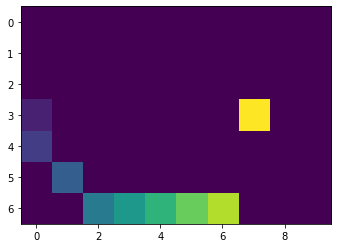

In [16]:
setup(king_moves, stochastic=False)
Q_k  = sarsa(grid, 8000)
path = trace(grid, Q_k)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

## Result for Compass Moves after 8000 episodes
Learns a (optimal) path with length of 15

Total Reward: -15
[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1)]


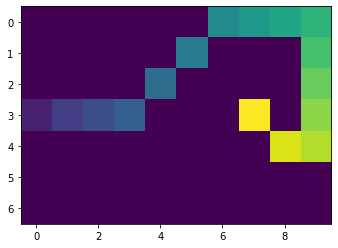

In [15]:
setup(compass_moves, stochastic=False)
Q_c  = sarsa(grid, 8000)
path = trace(grid, Q_c)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

## Result for King Moves after 8000 episodes + Stochastic Wind
Gives different results each time due to stochasticity. They can get quite messy

Total Reward: -17
[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, -1), (1, -1), (1, 0), (1, 0)]


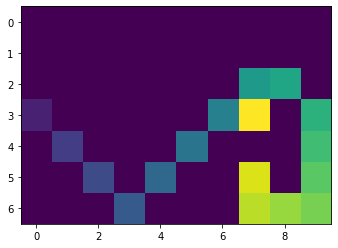

In [18]:
setup(king_moves, stochastic=True)
Q_ks = sarsa(grid, 8000)
path = trace(grid, Q_ks)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

# Result for King Moves + No-op after 8000 episodes
It doesn't get better if we include the no-op

Total Reward: -8
[(1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, 1)]


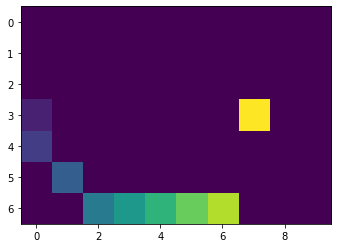

In [13]:
setup(king_moves_noop, stochastic=False)
Q_kn = sarsa(grid, 8000)
path = trace(grid, Q_kn)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)